# CNN Approach to Time-series classification

In this notebook we demonstrate a transformation-based approach to time series classification. A time-series is transformed into an image by one of several methods and the classifier is trained directly on the image data.

The notebook automates preprocess of data on any of the 128 UCR time series classification datasets. Download here:
http://www.timeseriesclassification.com/index.php, unzip, and set your pwd there to run this notebook as is.

In [2]:
from scipy.io import arff
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from fastai import *
from fastai.vision import * 
from fastai.vision.data import ImageDataBunch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pyts.image import GASF, GADF, MTF, RecurrencePlots
import pdb

In [5]:
def cleanup(df):
    #df.sample(df.shape[0], replace=False).reset_index(drop=True)
    df.columns = [k for k in range(df.shape[1]-1)]+['target']
    for k in df.columns[:-1]:
        df[k] = df[k].astype('float')
    if df.target.dtype == 'object':
        df['target'] = df['target'].apply(lambda x: x.decode('ascii')).astype('int')
    if sorted(df.target.unique()) != list(np.arange(df.target.nunique())):
        new_targs = pd.DataFrame({'target':df.target.unique()}).reset_index()
        df = pd.merge(df, new_targs, left_on='target', right_on='target').drop('target',axis=1).rename(columns={'index':'target'})
    ts = pd.melt(df.reset_index(), id_vars=['index','target'], var_name='time').rename(columns={'index':'id'})
    ts = ts.groupby(['id','time','target']).value.mean().reset_index()
    return df, ts

def graph_ts(ts):
    for k in ts.target.unique():
        fig, axes = plt.subplots(figsize=(15,5))
        sns.tsplot(ts[ts.target == k], time='time', unit='id', condition='target', value='value', err_style='unit_traces', ax=axes)    
    fig, axes = plt.subplots(figsize=(15,5))
    sns.tsplot(ts, time='time', unit='id', condition='target', value='value', err_style='unit_traces', ax=axes)
    return None

def prep_data(task='Oliveoil', cmap='rainbow', method='GASF'):
    path = Path('NewTSCProblems/%s'%(task))
    for phase in ['train','test']:
        data = arff.loadarff('NewTSCProblems/%s/%s_%s.arff'%(task,task,phase))
        df = pd.DataFrame(data[0])
        df, ts = cleanup(df)
        graph_ts(ts)
        labels = df.target.unique()
        image_size = df.shape[1]-1
        if method == 'GASF':
            transformer = GASF(image_size=image_size)
        elif method == 'GADF':
            transformer = GADF(image_size=image_size)
        elif method == 'MTF':
            transformer = MTF(image_size=64)
        elif method == 'RP':
            transformer == RecurrencePlots(dimension=1, epsilon=None, percentage=10)
        else:
            method = 'Unaltered'
        method_path = path/f'{method}'
        method_path.mkdir(exist_ok=True)
        phase_path = method_path/f'{phase}'
        phase_path.mkdir(exist_ok=True)
        if method != 'Unaltered':
            image_data = transformer.fit_transform(df[df.columns[:-1]])
            for label in labels:
                label_path = phase_path/f'{label}'
                label_path.mkdir(exist_ok=True)
                sub_df = df[df.target == label]
                idxs = sub_df.index
                for idx in idxs:
                    plt.figure(figsize=(10,10))
                    plt.imshow(image_data[idx], cmap=cmap, origin='lower')
                    plt.savefig(label_path/f'{idx}')
                    plt.close('all')
        else: 
            for label in labels:
                label_path = phase_path/f'{label}'
                label_path.mkdir(exist_ok=True)
                sub_df = df[df.target == label]
                idxs = sub_df.index
                for idx in idxs:
                    plt.figure(figsize=(10,10))
                    plt.plot(df.iloc[idx].values)
                    plt.savefig(label_path/f'{idx}')
                    plt.close('all')    
    return None



In [11]:
task='oliveoil'
method = 'GADF'
prep_data(task=task, method=method)

/Users/maxbaranov/anaconda/envs/pers/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/maxbaranov/anaconda/envs/pers/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [12]:
path = Path('NewTSCProblems/%s/%s'%(task,method))
data = ImageDataBunch.from_folder(path, size=224, train='train', valid='test')

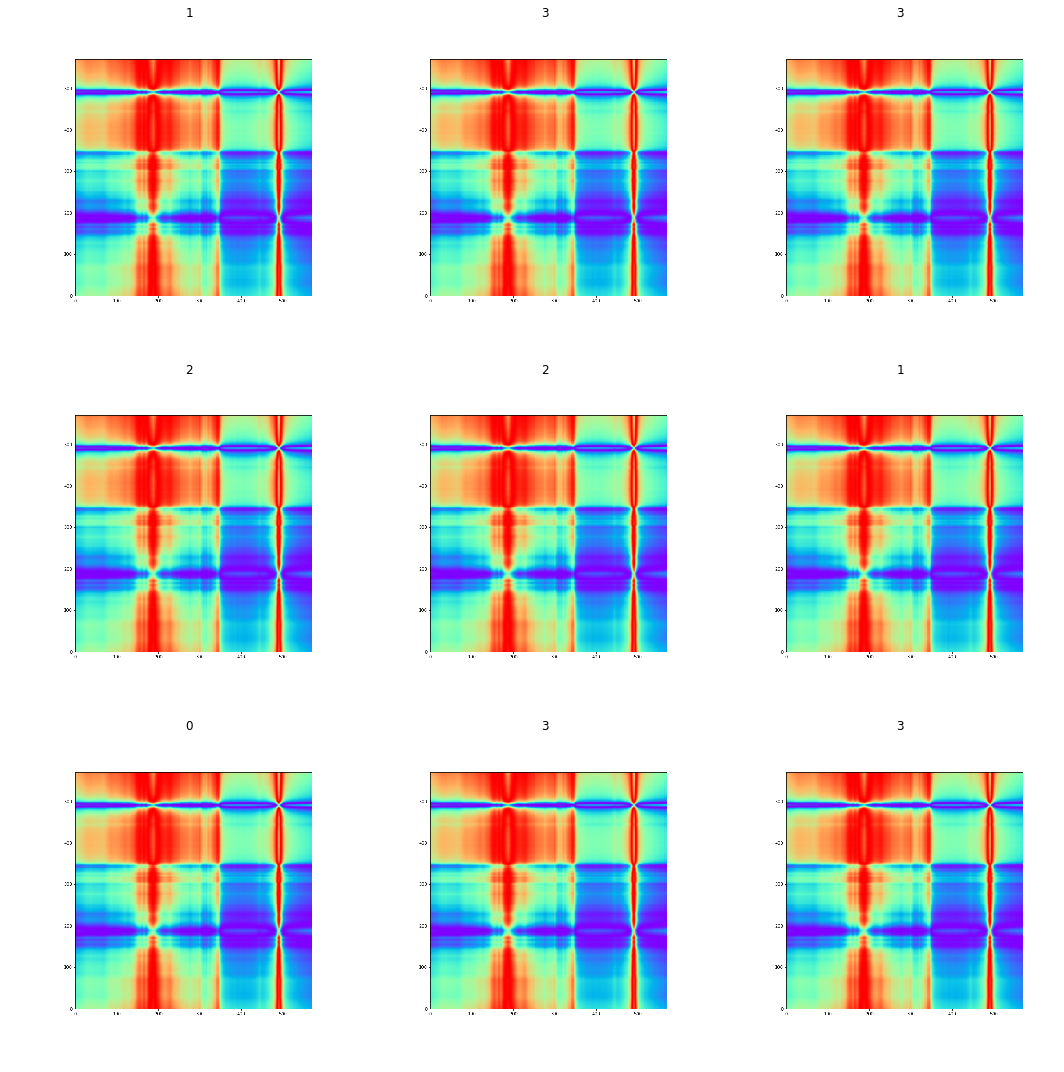

In [13]:
data.show_batch(rows=3, figsize=(15,15))

In [15]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, max_lr=3e-3)